# Learning Seattle's Work Habits from Bicycle Counts

This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) by Jake VanderPlas on the blog [Pythonic Perambulations](http://jakevdp.github.io).


The content is MIT licensed.*

## The Data

The data we will use here are the hourly bicycle counts on Seattle's.

<center><img src="Fremont_bridge_pedal.jpeg"></center>

In [1]:
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

In [2]:
import pandas as pd
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [3]:
data.tail()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2017-12-31 19:00:00,9.0,12.0
2017-12-31 20:00:00,6.0,8.0
2017-12-31 21:00:00,3.0,10.0
2017-12-31 22:00:00,7.0,6.0
2017-12-31 23:00:00,7.0,9.0


We'll do some quick data cleaning: we'll rename the columns to the shorter "West" and "East", set any missing values to zero, and add a "Total" column:

In [4]:
data.columns = ['West', 'East']
data.fillna(0, inplace=True)
data['Total'] = data.eval('East + West')

data.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


## Visualize the Data

In [5]:
# first some standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot styling
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import numpy as np

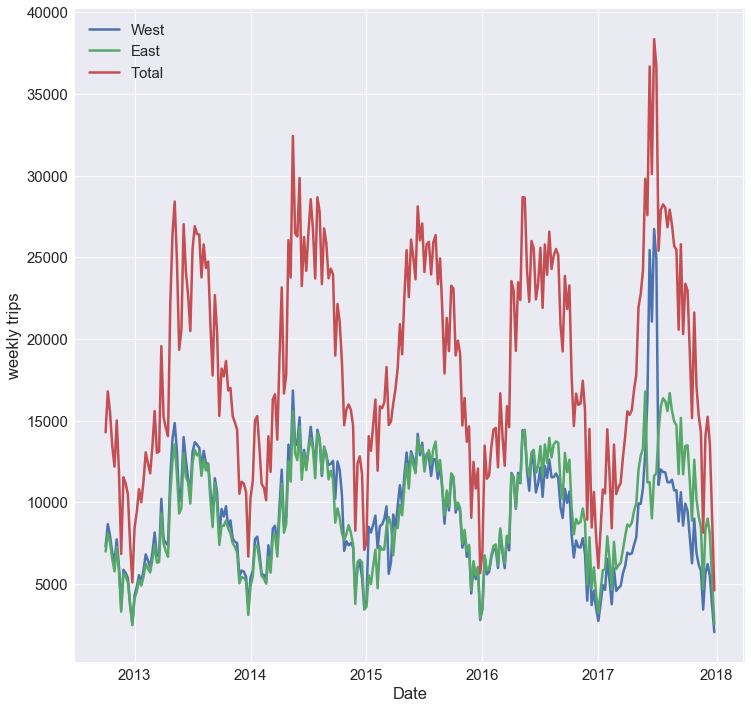

In [6]:
data.resample('W').sum().plot(figsize=(12, 12))
plt.ylabel('weekly trips');

## Extracting Knowledge from the Data

From here, we could do a variety of other visualizations based on our intuition about what might affect bicycle counts.
For example, we could look at the effect of the days of the week, the effect of the weather, and other factors [that I explored previously](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/).
But we could also proceed by letting the dataset speak for itself, and use *unsupervised machine learning* techniques (that is, machine learning without reference to data labels) to learn what the data have to tell us.

We will consider each day in the dataset as its own separate entity (or *sample*, in usual machine learning parlance).
For each day, we have 48 observations: two observations (east and west sidewalk sensors) for each of the 24 hour-long periods.
By examining the days in light of these observations and doing some careful analysis, we should be able to extract meaningful quantitative statements from the data themselves, without the need to lean on any other assumptions.

## Transforming the Data

In [7]:
pivoted = data.pivot_table(['East', 'West'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
pivoted.head()

East                                    ... West                 \
Date         0  1  2  3  4   5   6    7    8    9  ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104 ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94 ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81 ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55 ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36 ...  126  122  132  118   

                                     
Date         18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]

In [8]:
X = pivoted.values
X.shape

(1916, 48)

Our data consists of just over 1916 days, each with the aforementioned 48 measurements.

## Extracting Knowledge from the Data


## Visualizing the Data

We can think of this data now as representing 1001 distinct objects which live in a *48-dimensional* space: the value of each dimension is the number of bicycle trips measured on a particular side of the bridge at a particular hour.
Visualizing 48-dimensional data is quite difficult, so instead we will use a standard *dimensionality reduction* technique to project this to a more manageable size.

The technique we'll use is [Principal Component Analysis (PCA)](http://scikit-learn.org/stable/modules/decomposition.html), a fast linear projection which rotates the data such that the projection preserves the maximum variance.
We can ask for components preserving 90% of the variance as follows:

### Dimensionality Reduction

In [9]:
from sklearn.decomposition import PCA

Xpca = PCA(n_components=2).fit_transform(X)
Xpca.shape

(1916, 2)

The output has two dimensions, which means that these two projected components describe at least 90% of the total variance in the dataset.
While 48-dimensional data is difficult to plot, we certainly know how to plot two-dimensional data: we'll do a simple scatter plot, and for reference we'll color each point according to the total number of trips taken that day:

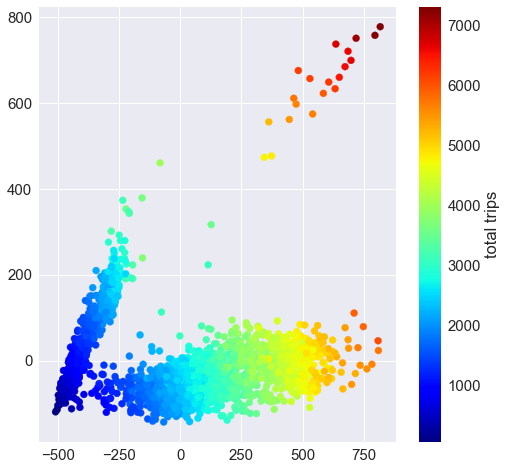

In [10]:
total_trips = X.sum(1)

plt.figure(figsize=(8, 8))
plt.scatter(
    Xpca[:, 0],
    Xpca[:, 1],
    c=total_trips,
    cmap='jet'
)

plt.colorbar(label='total trips');

In [11]:
from matplotlib import cm
colormap = cm.jet
znorm = total_trips - total_trips.min()
znorm = znorm / znorm.astype(np.float).ptp()
print(znorm.min(), znorm.max())
color = colormap(znorm)

0.0 1.0


In [12]:
Xpca2 = PCA(n_components=3).fit_transform(X)
Xpca2.shape

(1916, 3)

In [13]:
import ipyvolume as ipv

ipv.figure(figsize=(8, 8))
ipv.scatter(Xpca2[:, 0], Xpca2[:, 1], Xpca2[:, 2], marker="sphere", color=color[..., 0:3])
ipv.show()

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color=array([[0.41429475, 1.        , 0.55344719],
       [0.38899431, 1.        , 0.57874763],
       [0.24984187, 1.        , 0.71790006],
       ...,
       [0.        , 0.        , 0.83868093],
       [0.        , 0.        , 0.90998217],
       [0.        , 0.        , 0.92780749]]), color_selected=array('white', dtype='<U5'), geo='sphere', size=array(2), size_selected=array(2.6), x=array([ 243.3562548 ,  188.05657871,  108.2346947 , ..., -413.40980898,
       -455.38336433, -462.07453511]), y=array([ -0.97521184,  14.67212905,  24.35457136, ..., -96.50677519,
       -30.56369976, -27.10625103]), z=array([  9.90783067, -12.27880592, -11.84569552, ...,  66.64066034,
        20.12055278,  16.2929778 ]))], style={'axes': {'visible': True, 'label': {'color': 'black'}, 'ticklabel': {'color': 'black'}, 'color': 'black'}, 'box': {'visible': True}, 'background-color': 'white'}, tf=None, width=400, xlim=[-510.9130174234473, 817.7308646567793], ylim=[-143.20706576376526, 777.6460144067311], zlim=[-374.15307064196975, 524.681826538192]),))

We see that the days lie in two quite distinct groups, and that the total number of trips increases along the length of each projected cluster.
Further, the two groups begin to be less distinguishable when the number of trips during the day is very small.

I find this extremely interesting: from the raw data, we can determine that there are basically *two primary types of days* for Seattle bicyclists.
Let's model these clusters and try to figure out what these types-of-day are.

## Unsupervised Clustering

When you have groups of data you'd like to automatically separate, but no previously-determined labels for the groups, the type of algorithm you are looking at is a *clustering* algorithm.
There are a number of clustering algorithms out there, but for nicely-defined oval-shaped blobs like we see above, [Gaussian Mixture Models](http://scikit-learn.org/stable/modules/mixture.html) are a very good choice.
We can compute the Gaussian Mixture Model of the data using, again, scikit-learn, and quickly plot the predicted labels for the points:

In [14]:
from sklearn.mixture import GaussianMixture 
gmm = GaussianMixture(3, covariance_type='full', random_state=0)
gmm.fit(Xpca)

cluster_label = gmm.predict(Xpca)

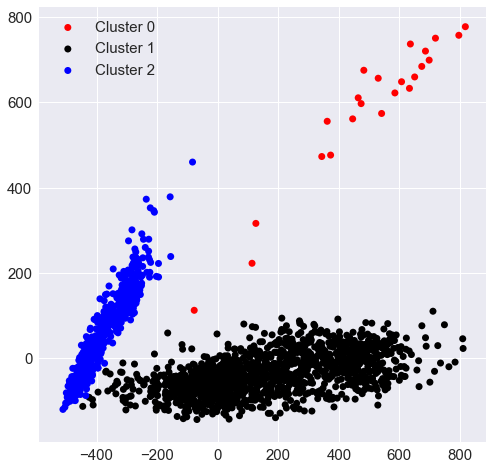

In [15]:
plt.figure(figsize=(8, 8))

for i, color in enumerate(['red', 'black', 'blue']):
    inds = cluster_label == i
    x, y = Xpca[inds, 0], Xpca[inds, 1]
    plt.scatter(x, y, c=color, label="Cluster {}".format(i),
               edgecolors='none')

plt.legend()

This clustering seems to have done the job, and separated the two groups we are interested in.
Let's join these inferred cluster labels to the initial dataset:

In [16]:
pivoted['Cluster'] = cluster_label
data = data.join(pivoted['Cluster'], on=data.index.date)
data.head()

,West,East,Total,Cluster
Date,,,,
2012-10-03 00:00:00,4.0,9.0,13.0,1
2012-10-03 01:00:00,4.0,6.0,10.0,1
2012-10-03 02:00:00,1.0,1.0,2.0,1
2012-10-03 03:00:00,2.0,3.0,5.0,1
2012-10-03 04:00:00,6.0,1.0,7.0,1


Now we can find the average trend by cluster and time using a GroupBy within this updated dataset

In [17]:
by_hour = data.groupby(['Cluster', data.index.time]).mean()
by_hour.head()

West      East      Total
Cluster                                         
0       00:00:00  10.913043  7.304348  18.217391
        01:00:00   4.913043  3.086957   8.000000
        02:00:00   2.608696  1.304348   3.913043
        03:00:00   2.652174  1.260870   3.913043
        04:00:00   7.391304  4.130435  11.521739

Finally, we can plot the average hourly trend among the days within each cluster:

In [18]:
def show_clusters():
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    hourly_ticks = 4 * 60 * 60 * np.arange(6)

    for i, ax in enumerate(axes.flatten()[:3]):
        by_hour.loc[i].plot(y="West", ax=ax, xticks=hourly_ticks)
        by_hour.loc[i].plot(y="East", ax=ax, xticks=hourly_ticks)
        ax.set_title('Cluster {0}'.format(i))
        ax.set_ylabel('average hourly trips')

    for i, color in enumerate(['red', 'black', 'blue']):
        inds = cluster_label == i
        x, y = Xpca[inds, 0], Xpca[inds, 1]
        axes[1, 1].scatter(x, y, c=color, label="Cluster {}".format(i),
                   edgecolors='none')

    axes[1, 1].legend()

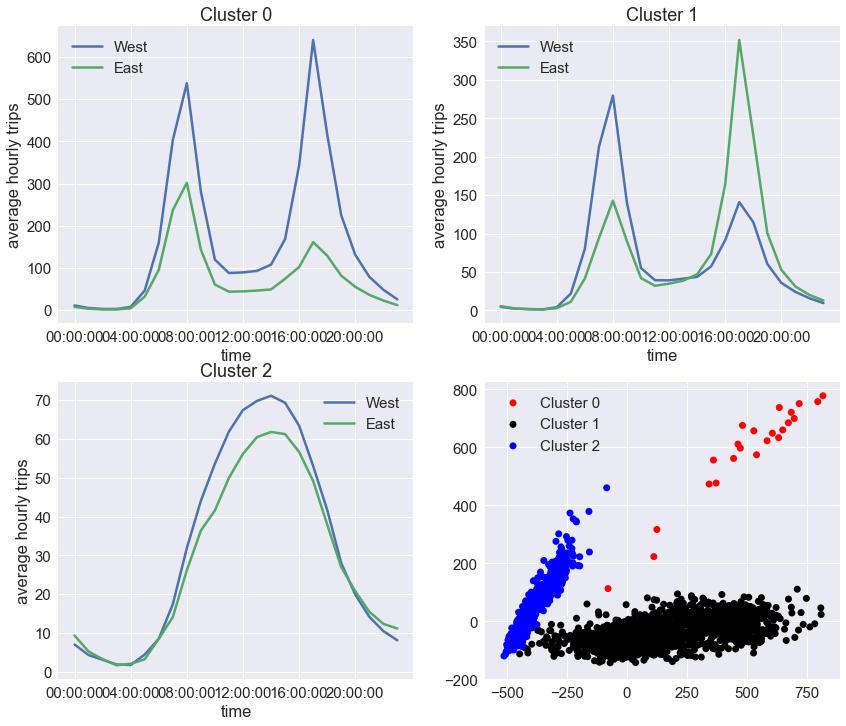

In [19]:
show_clusters()

These plots give us some insight into the interpretation of the two clusters: the first cluster shows a sharp bimodal traffic pattern, while the second shows a wide unimodal pattern.

In the bimodal cluster, we see a peak around 8:00am which is dominated by cyclists on the west sidewalk, and another peak around 5:00pm which is dominated by cyclists on the east sidewalk.
This is very clearly a commute pattern, with the majority of cyclists riding toward downtown Seattle in the morning, and away from downtown Seattle in the evening.

In the unimodal cluster, we see fairly steady traffic in each direction beginning early in the morning and going until late at night, with a peak around 2:00 in the afternoon.
This is very clearly a recreational pattern of use, with people out riding through the entire day.

I find this is fascinating: from simple unsupervised dimensionality reduction and clustering, we've discovered two distinct classes of days in the data, and found that these classes have very intuitive explanations.

## Seattle's Work Habits

Let's go one step deeper and figure out what we can learn about people (well, bicycle commuters) in Seattle from just this hourly commute data.
As a rough approximation, you might guess that these two classes of data might be largely reflective of workdays in the first cluster, and non-work days in the second.
We can check this intuition by re-plotting our projected data, except labeling them by day of the week:

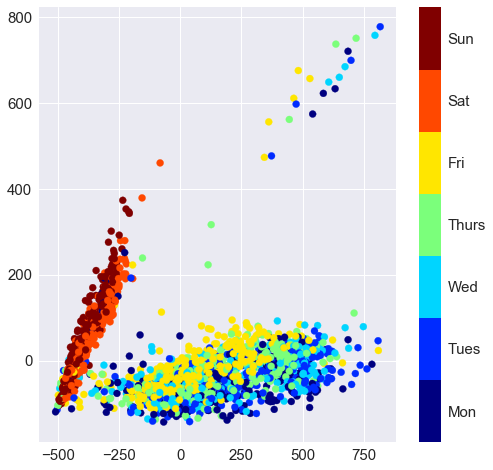

In [20]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek

plt.figure(figsize=(8, 8))
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

We see that the weekday/weekend intuition holds, but only to a point: in particular, it is clear that **there are a handful of weekdays which follow the typical weekend pattern!**
Further, it's interesting to note that Fridays tend to be pulled closer to weekend days in this plot, though as a whole they still fall solidly in the work-day cluster.

Let's take a closer look at the "special" weekdays that fall in the "wrong" cluster.
We start by constructing a dataset listing the cluster id and the day of the week for each of the dates in our dataset:

In [21]:
results = pd.DataFrame({'cluster': cluster_label,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted.index)
results.head()

,cluster,is_weekend,weekday
2012-10-03,1,False,Wed
2012-10-04,1,False,Thu
2012-10-05,1,False,Fri
2012-10-06,2,True,Sat
2012-10-07,2,True,Sun


In [22]:
results[results["cluster"]==0]

,cluster,is_weekend,weekday
2013-07-05,0,False,Fri
2017-06-01,0,False,Thu
2017-06-02,0,False,Fri
2017-06-05,0,False,Mon
2017-06-06,0,False,Tue
2017-06-07,0,False,Wed
2017-06-08,0,False,Thu
2017-06-09,0,False,Fri
2017-06-12,0,False,Mon
2017-06-13,0,False,Tue


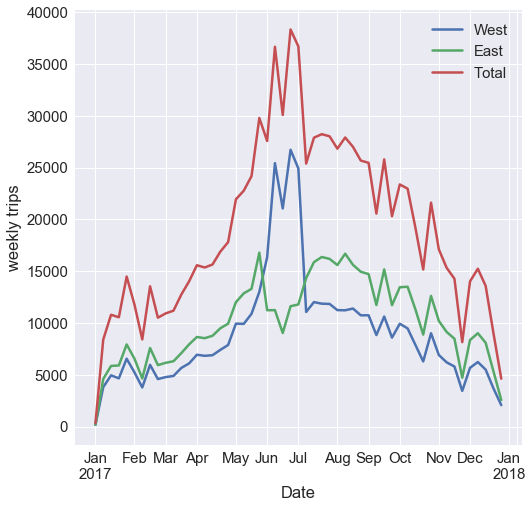

In [23]:
data[data.index.year==2017].drop("Cluster", axis=1).resample('W').sum().plot(figsize=(8, 8))
plt.ylabel('weekly trips');

## What happened on June 2017?

<center><img src="limeback_june.png"></center>